In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import math

bs_df = pd.read_excel("BS_EN_Dataset.xlsx")
#Show the 1st 5 rows of the original dataset
bs_df.head()

,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,Cu,Cr,Ni,Mo,Al,Ti,V,Nb,B,Classification
0,S275N,BS ISO 630-3:2021,22,275,370-510,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.3,0-0.1,0-0.2,0-0.05,0-0.05,0-0.05,-,Non-alloy steels
1,S355N,BS ISO 630-3:2021,20,355,470-630,0-0.2,0-0.5,0.9-1.65,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.5,0-0.1,0-0.2,0-0.05,0-0.12,0-0.05,-,Non-alloy steels
2,S390N,BS ISO 630-3:2021,18,390,490-650,0-0.2,0-0.5,0.9-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.5,0-0.1,0-0.2,-,-,-,-,Non-alloy steels
3,S420N,BS ISO 630-3:2021,17,420,520-680,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.8,0-0.1,0-0.2,0-0.05,0-0.2,0-0.05,-,"Structural, pressure vessel and engineering st..."
4,S460N,BS ISO 630-3:2021,15,460,540-720,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.8,0-0.1,0-0.2,0-0.05,0-0.2,0-0.5,-,"Structural, pressure vessel and engineering st..."


In [3]:
# This function splits each element the dataset into its minimum and maximum values based on the "-" separator.
# The resulting minimum and maximum values are assigned to new columns with "min_" and "max_" followed by the element, respectively.
def split_dataset(df):
    for elem in df.columns[5:20]:  # loop through each column from index 5 to 19
        df = df.assign(min_ = lambda x: 0.0)  # add a new column for minimum values, initialized to 0.0
        df = df.assign(max_ = lambda x: 0.0)  # add a new column for maximum values, initialized to 0.0
        df.rename(columns = {"min_":"min_"+elem, "max_":"max_"+elem}, inplace = True)  # rename the new columns
        for i in range(len(df)):  # loop through each row of the DataFrame
            try:
                min_, max_ = split_row(df.iloc[[i]], elem)  # split the current element into its minimum and maximum values
                df.at[i, "min_"+elem] = min_  # assign the minimum value to the corresponding new column
                df.at[i, "max_"+elem] = max_  # assign the maximum value to the corresponding new column
            except:
                continue
    return df

# This helper function takes a DataFrame row and a column name as input and returns the minimum and maximum values of the element in the given column.
def split_row(row, elem):
    min_ = row.reset_index()[elem][0].split("-")[0]  # extract the minimum value of the element
    max_ = row.reset_index()[elem][0].split("-")[1]  # extract the maximum value of the element
    return float(min_), float(max_)

# Call the split_dataset function on a DataFrame bs_df and assign the resulting DataFrame to df_split.
# Show the first 5 rows of the resulting DataFrame.
df_split = split_dataset(bs_df)
df_split.head()


,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,min_Al,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B
0,S275N,BS ISO 630-3:2021,22,275,370-510,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0
1,S355N,BS ISO 630-3:2021,20,355,470-630,0-0.2,0-0.5,0.9-1.65,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.12,0.0,0.05,0.0,0.0
2,S390N,BS ISO 630-3:2021,18,390,490-650,0-0.2,0-0.5,0.9-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
3,S420N,BS ISO 630-3:2021,17,420,520-680,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.20,0.0,0.05,0.0,0.0
4,S460N,BS ISO 630-3:2021,15,460,540-720,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.20,0.0,0.50,0.0,0.0


In [4]:
# Create expanded dataset

# Function to expand a row when either the yield strength or tensile strength is a range
def expand_row(row, feature, k):
    # Split the range of the given feature into a list of integers
    feat_range = row.reset_index()[feature][0].split("-")
    feat_range = list(np.linspace(int(feat_range[0]), int(feat_range[1]), k))
    feat_range = [int(i) for i in feat_range]
    
    # Append k-1 copies of the original row to the row DataFrame
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    
    # Set the feature column of the new rows to the corresponding values in feat_range
    row[feature] = feat_range
    return row

# Function to expand a row when both the yield strength and tensile strength are ranges
def expand_row_2(row, k):
    # Split the yield strength range into a list of integers and calculate the mean value
    yield_range = row.reset_index()["Yield Strength"][0].split("-")
    mean_yield = int((int(yield_range[0]) + int(yield_range[1])) / 2)
    row = row.reset_index()
    # Set the yield strength of the original row to the mean value
    row.at[0, "Yield Strength"] = mean_yield
    # Expand the row using the expand_row function with "Tensile Strength" as the feature
    return expand_row(row, "Tensile Strength", k)

# Function to expand a row when both the yield strength and tensile strength are single values
def expand_row_3(row, k):
    # Generate a list of k values within +/- 4 of the original tensile strength value
    feat_range = list(np.linspace(row["Tensile Strength"] - 4, row["Tensile Strength"] + 5, k))
    feat_range = [int(i) for i in feat_range]
    
    # Append k-1 copies of the original row to the row DataFrame
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    
    # Set the Tensile Strength column of the new rows to the corresponding values in feat_range
    row["Tensile Strength"] = feat_range
    return row

# Function to expand a DataFrame using the expand_row functions
def expand_df(df, k):
    df2 = pd.DataFrame(columns=list(df.columns))
    for i in range(len(df)):
        row = df.iloc[[i]]
        # Determine which expand_row function to use based on the types of the Yield Strength and Tensile Strength columns
        if type(row.reset_index()["Tensile Strength"][0]) == str and type(row.reset_index()["Yield Strength"][0]) != str:
            expanded_row = expand_row(row, "Tensile Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row(row, "Yield Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) == str:
            expanded_row = expand_row_2(row, k)
        elif type(row.reset_index()["Yield Strength"][0]) != str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row_3(row, k)
        df2 = pd.concat([df2, expanded_row], ignore_index=True)
    return df2

df2 = expand_df(df_split, 76)
#Show the 1st 5 rows of the dataset after the tensile properties are expanded
df2.head(5)

,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B,index
0,S275N,BS ISO 630-3:2021,22,275,370,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
1,S275N,BS ISO 630-3:2021,22,275,371,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
2,S275N,BS ISO 630-3:2021,22,275,373,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
3,S275N,BS ISO 630-3:2021,22,275,375,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
4,S275N,BS ISO 630-3:2021,22,275,377,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN


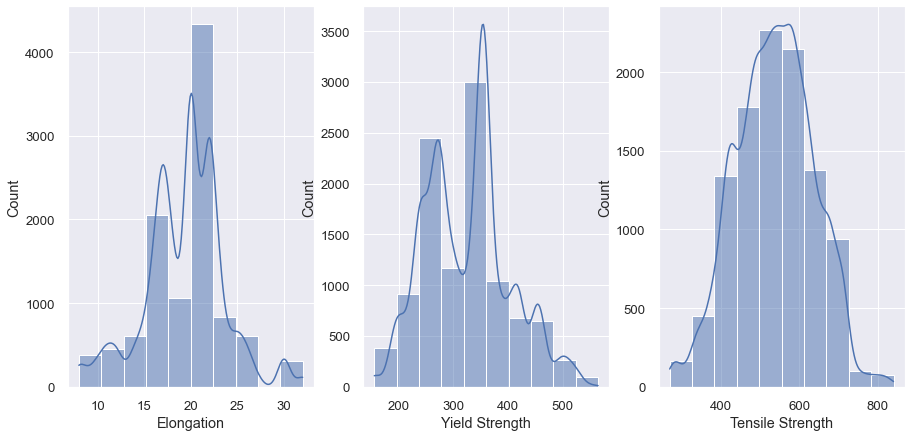

In [5]:
### Visualize the elongation, yield strength, and tensile strength data

# Use the seaborn style and set the font size
plt.style.use("seaborn")
sns.set(font_scale=1.2)

# Create the figure and axis for the subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

# Plot a histogram for elongation on the first axis
sns.histplot(df2["Elongation"], kde=True, ax=ax1, bins=10)

# Plot a histogram for yield strength on the second axis
sns.histplot(data=df2["Yield Strength"], kde=True, ax=ax2, bins=10)

# Plot a histogram for tensile strength on the third axis
sns.histplot(data=df2["Tensile Strength"], kde=True, ax=ax3, bins=10)

# Show the plot
plt.show()

# Close the plot
plt.close()


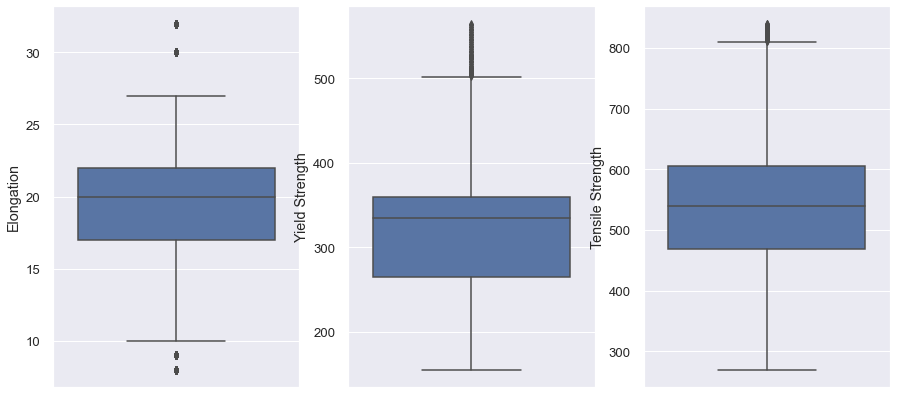

In [6]:
##Better visualize the input data using boxplots that show: mean, interquartile range, and outliers. dataiku, data fusion

# Set plotting style and font size
plt.style.use("seaborn")
sns.set(font_scale=1.2)

# Create the figure and axis
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

# Assigning a graph to each axis
sns.boxplot(y=df2["Elongation"], ax=ax1)
sns.boxplot(y=df2["Yield Strength"], ax=ax2)
sns.boxplot(y=df2["Tensile Strength"], ax=ax3)

# Display the plot
plt.show()

In [7]:
###Prepare the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# change data types to integers
df2 = df2.astype({"Elongation": int, "Yield Strength": int, "Tensile Strength": int})

# normalize new input data (elongation, yield strength, tensile strength)
def normalize_data(df = df2):
    df_min_max_scaled = df.copy() # create a copy of the input DataFrame
    # iterate over each column in the copy and normalize it
    for column in df_min_max_scaled.columns[2:5]:
        df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
    # convert the normalized DataFrame to a list
    x = df_min_max_scaled[df_min_max_scaled.columns[2:5]].values.tolist()
    return x # return the list

# split the data to training and testing samples
def split_data(output, df=df2):
    x = normalize_data(df) # normalize the data using the previous function
    y = df[output].values.tolist() # extract the output column and convert it to a list
    # split the data into training and testing sets using a 75:25 split and a fixed random state of 3
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3)
    return x_train, x_test, y_train, y_test # return the training and testing sets

# normalize a new datapoint
def normalize_point(point):
    df_slice = df2[df2.columns[2:5]] # extract a slice of the original DataFrame containing the input columns
    # iterate over each input column in the slice and normalize the corresponding value in the input point
    for i in range(len(df_slice.columns)):
        point[i] = (point[i] - df_slice[df_slice.columns[i]].min()) / (df_slice[df_slice.columns[i]].max() - df_slice[df_slice.columns[i]].min())
    return np.array([point]) # convert the normalized input point to a NumPy array and return it


In [8]:
#Statistics for the dataset's features
df2.describe()

,Elongation,Yield Strength,Tensile Strength,min_C,max_C,min_Si,max_Si,min_Mn,max_Mn,min_P,...,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B,index
count,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.0,...,10640.000000,10640.0,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,152.000000
mean,19.350000,325.600752,537.382989,0.079571,0.225286,0.013214,0.417500,0.522857,1.232500,0.0,...,0.025679,0.0,0.018857,0.001143,0.044286,0.000107,0.024571,0.000014,0.000086,106.000000
std,4.232599,77.093987,99.026759,0.153750,0.127881,0.039012,0.149879,0.441462,0.491774,0.0,...,0.059609,0.0,0.028477,0.009494,0.062683,0.001263,0.048263,0.000168,0.000541,15.049587
min,8.000000,155.000000,270.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000
25%,17.000000,265.000000,469.000000,0.000000,0.167500,0.000000,0.350000,0.000000,0.875000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000
50%,20.000000,335.000000,540.000000,0.000000,0.200000,0.000000,0.400000,0.500000,1.400000,0.0,...,0.007500,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,106.000000
75%,22.000000,360.000000,606.000000,0.105000,0.220000,0.000000,0.500000,0.912500,1.650000,0.0,...,0.020000,0.0,0.030000,0.000000,0.060000,0.000000,0.050000,0.000000,0.000000,121.000000
max,32.000000,565.000000,840.000000,0.570000,0.650000,0.150000,0.600000,1.400000,1.800000,0.0,...,0.550000,0.0,0.150000,0.080000,0.200000,0.015000,0.500000,0.002000,0.006000,121.000000


In [18]:
# Run KNN model and evaluate it using k-fold cross-validation for R-squared score and RMSE
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


#train the KNN model
def run_model_KNN_reg(n_neighbours, n_folds = 5):

    # Define the input independent variable
    X = np.array(normalize_data(df2))

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state = 42)

    # Save the cross-validation score for each element
    cross_valid_dict_r2 = {}
    cross_valid_dict_rmse = {}

    for elem in df2.columns[21:-1]:
        # Define the dependent variable 
        y = np.array(df2[elem].values.tolist())

        # Initialize the r-squared scores list for each fold
        train_r2 = np.zeros(n_folds)
        test_r2 = np.zeros(n_folds)
        train_rmse = np.zeros(n_folds)
        test_rmse = np.zeros(n_folds)

        # Loop over the folds
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            # Split the data into training and test sets
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

            knn_model = KNeighborsRegressor(n_neighbors=n_neighbours)
            
            # Fit the model to the training data
            knn_model.fit(X_train, y_train)
            
            # Make predictions on the training and test data
            y_train_pred = knn_model.predict(X_train)
            y_test_pred = knn_model.predict(X_test)
            
            # Compute the R^2 score for the training and test data
            train_r2[i] = r2_score(y_train, y_train_pred)
            test_r2[i] = r2_score(y_test, y_test_pred)

            # Compute the RMSE score for the training and test data
            train_rmse[i] = mean_squared_error(y_train, y_train_pred, squared=False)
            test_rmse[i] = mean_squared_error(y_test, y_test_pred, squared=False)
            
        # Compute the mean and standard deviation of the R^2 scores for the training and test data accross all folds
        mean_train_r2 = np.mean(train_r2)
        std_train_r2 = np.std(train_r2)
        mean_test_r2 = np.mean(test_r2)
        std_test_r2 = np.std(test_r2)

        # Compute the mean and standard deviation of the RMSE scores for the training and test data accross all folds
        mean_train_rmse = np.mean(train_rmse)
        std_train_rmse = np.std(train_rmse)
        mean_test_rmse = np.mean(test_rmse)
        std_test_rmse = np.std(test_rmse)

        # Save the results for each element
        cross_valid_dict_r2[elem] = [[mean_test_r2, std_test_r2], [mean_train_r2, std_train_r2]]
        cross_valid_dict_rmse[elem] = [[mean_test_rmse, std_test_rmse], [mean_train_rmse, std_train_rmse]]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_needed_elems(cross_valid_dict_r2, cross_valid_dict_rmse)
    return cross_valid_dict_r2, cross_valid_dict_rmse

# Run the model
cross_valid_dict_r2, cross_valid_dict_rmse = run_model_KNN_reg(6, 5)

In [17]:
# Improve prediction for some elements by removing outliers from their data

# Function for evaluating model after removing needed outliers
def improve_elem(elem, df_new, cross_valid_dict_r2, cross_valid_dict_rmse, n_folds = 5):
    X = np.array(normalize_data(df_new))
    y = np.array(df_new[elem].values.tolist())
    kf = KFold(n_splits=n_folds, shuffle=True, random_state = 42)
    train_r2 = np.zeros(n_folds)
    test_r2 = np.zeros(n_folds)
    train_rmse = np.zeros(n_folds)
    test_rmse = np.zeros(n_folds)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        knn_model = KNeighborsRegressor(n_neighbors=6)
        knn_model.fit(X_train, y_train)
        y_train_pred = knn_model.predict(X_train)
        y_test_pred = knn_model.predict(X_test)
        train_r2[i] = r2_score(y_train, y_train_pred)
        test_r2[i] = r2_score(y_test, y_test_pred)
        train_rmse[i] = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse[i] = mean_squared_error(y_test, y_test_pred, squared=False)
    mean_train_r2 = np.mean(train_r2)
    std_train_r2 = np.std(train_r2)
    mean_test_r2 = np.mean(test_r2)
    std_test_r2 = np.std(test_r2)
    mean_train_rmse = np.mean(train_rmse)
    std_train_rmse = np.std(train_rmse)
    mean_test_rmse = np.mean(test_rmse)
    std_test_rmse = np.std(test_rmse)
    cross_valid_dict_r2[elem] = [[mean_test_r2, std_test_r2], [mean_train_r2, std_train_r2]]
    cross_valid_dict_rmse[elem] = [[mean_test_rmse, std_test_rmse], [mean_train_rmse, std_train_rmse]]
    return cross_valid_dict_r2, cross_valid_dict_rmse
    
# Function to improve the elements needing improvement

def improve_needed_elems(cross_valid_dict_r2, cross_valid_dict_rmse):
    # Improve max_Al
    df_new = df2[(df2["max_Al"] != 0.550) & (df2["max_Al"] != 0.200)]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem("max_Al", df_new, cross_valid_dict_r2, cross_valid_dict_rmse)


    # Improve min_Si
    df_new = df2[df2["min_Si"] != 0.15]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem("min_Si", df_new, cross_valid_dict_r2, cross_valid_dict_rmse)

    # Imrove min_Nb
    df_new = df2[df2["min_Nb"] != 0.015]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem("min_Nb", df_new, cross_valid_dict_r2, cross_valid_dict_rmse)

    # Improve max_Nb
    df_new = df2[df2["max_Nb"] != 0.50]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem("max_Nb", df_new, cross_valid_dict_r2, cross_valid_dict_rmse)

    #Improve max_N
    df_new = df2[(df2["max_N"] != 12.000) & (df2["max_N"] != 0.300)]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem("max_N", df_new, cross_valid_dict_r2, cross_valid_dict_rmse)

    return cross_valid_dict_r2, cross_valid_dict_rmse

The average R^2 score for KNN regression on testing dataset: 0.902
The average R^2 score for KNN regression on training dataset: 0.928


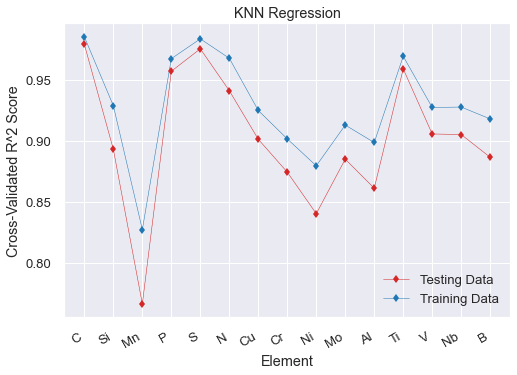

In [19]:
# Find the average cross-validated r-squared score for each element

# Define list which stores average R-squared scores
elems_r2_test = []
elems_r2_train = []

# Loop through all elements and find their average R-squared score accross their minimum and maximum limits
j = 0
for i in range(15):
    elems_r2_test.append((list(cross_valid_dict_r2.values())[i+j][0][0] + list(cross_valid_dict_r2.values())[i+j+1][0][0]) / 2)
    elems_r2_train.append((list(cross_valid_dict_r2.values())[i+j][1][0] + list(cross_valid_dict_r2.values())[i+j+1][1][0]) / 2)
    j += 1

# Plot the average cross-validated R-squared score for each element in training and testing data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], elems_r2_test, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], elems_r2_train, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
fig.autofmt_xdate()
plt.ylabel("Cross-Validated R^2 Score")
plt.xlabel("Element")
plt.title("KNN Regression")
plt.legend()

# Find the average cross-validated r-squared score for training and testing data accross all elements
avg_r2_test = sum(elems_r2_test) / len(elems_r2_test)
avg_r2_train = sum(elems_r2_train) / len(elems_r2_train)
print("The average R^2 score for KNN regression on testing dataset: {:.3f}".format(avg_r2_test))
print("The average R^2 score for KNN regression on training dataset: {:.3f}".format(avg_r2_train))

The average R^2 score for KNN regression on testing dataset: 0.066
The average R^2 score for KNN regression on training dataset: 0.056


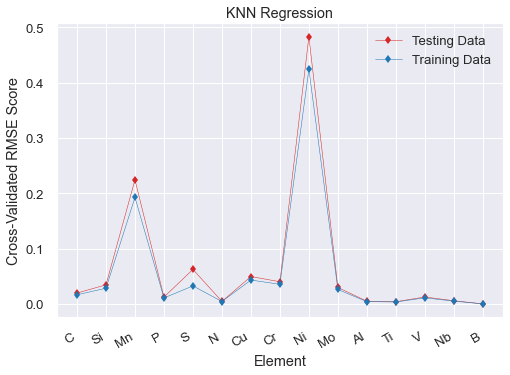

In [20]:
# Find average error for each element

# Define list which stores average RMSE scores
rmse_scores = []
rmse_scores_train = []

# Loop through all elements and find their average RMSE score accross their minimum and maximum limits
j = 0
for i in range(15):
    rmse_scores.append((list(cross_valid_dict_rmse.values())[i+j][0][0] + list(cross_valid_dict_rmse.values())[i+j+1][0][0]) / 2)
    rmse_scores_train.append((list(cross_valid_dict_rmse.values())[i+j][1][0] + list(cross_valid_dict_rmse.values())[i+j+1][1][0]) / 2)
    j += 1

# Plot the average cross-validated RMSE score for each element in training and testing data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], rmse_scores, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], rmse_scores_train, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
fig.autofmt_xdate()
plt.ylabel("Cross-Validated RMSE Score")
plt.xlabel("Element")
plt.title("KNN Regression")
plt.legend()

# Find the average cross-validated RMSE score for training and testing data accross all elements
avg_rmse_test = sum(rmse_scores) / len(rmse_scores)
avg_rmse_train = sum(rmse_scores_train) / len(rmse_scores_train)
print("The average R^2 score for KNN regression on testing dataset: {:.3f}".format(avg_rmse_test))
print("The average R^2 score for KNN regression on training dataset: {:.3f}".format(avg_rmse_train))

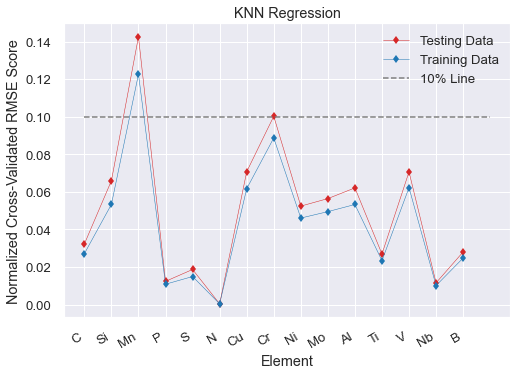

In [21]:
# Find the normalized RMSE score (RMSE score / range of output variable) for each element

# Find weighted RMSE score for min and max of each element
weighted_rmse_dict = {}
for i in range(len(cross_valid_dict_rmse)):
    elem = list(cross_valid_dict_rmse.keys())[i]
    elem_range = df2[elem].max() - df2[elem].min()
    if elem_range == 0:
        weighted_rmse_test = 0
        weighted_rmse_train = 0
    else:
        weighted_rmse_test = cross_valid_dict_rmse[elem][0][0] / elem_range
        weighted_rmse_train = cross_valid_dict_rmse[elem][1][0] / elem_range
    weighted_rmse_dict[elem] = [weighted_rmse_test, weighted_rmse_train]

# Find average of weighted RMSE score for each element accross minimum and maximum limits
weighted_rmse_scores_test = []
weighted_rmse_scores_train = []
j = 0
for i in range(15):
    weighted_rmse_scores_test.append((list(weighted_rmse_dict.values())[i+j][0] + list(weighted_rmse_dict.values())[i+j+1][0]) / 2)
    weighted_rmse_scores_train.append((list(weighted_rmse_dict.values())[i+j][1] + list(weighted_rmse_dict.values())[i+j+1][1]) / 2)
    j += 1

# Plot average weighted RMSE score for each element
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], weighted_rmse_scores_test, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], weighted_rmse_scores_train, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
plt.plot(np.linspace(0, 15, 100), [0.1]*100, "--", color = "tab:grey", label = "10% Line")
fig.autofmt_xdate()
plt.ylabel("Normalized Cross-Validated RMSE Score")
plt.xlabel("Element")
plt.title("KNN Regression")
plt.legend()

In [22]:
print(elems_r2_test)

[0.9793903704461899, 0.8931237837809316, 0.7660612538860376, 0.9573012498098752, 0.9757971308413436, 0.9413581050709589, 0.9013972011615967, 0.8743697613412036, 0.8402187462400317, 0.8850438258542491, 0.8611414374541133, 0.9592908766262369, 0.9057644894259789, 0.9053177438380191, 0.8866071980695475]


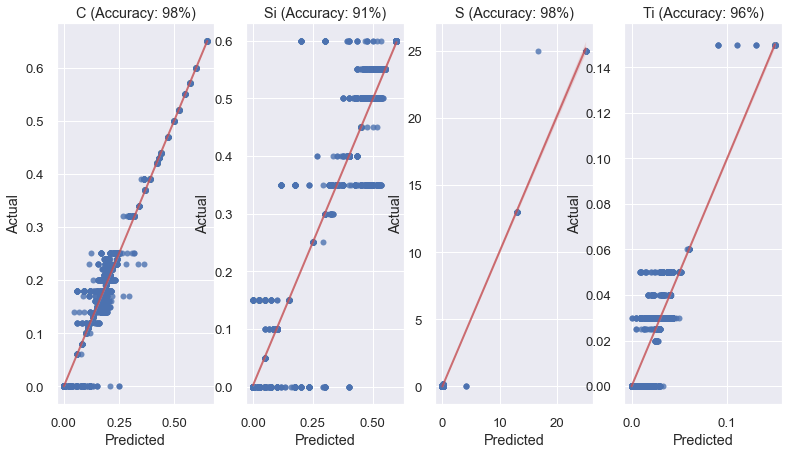

In [23]:
##Visualize polynomial regression performance on example elements

#Elements to plot their performance
example_elems = ['C','Si','S', "Ti"]
accuracy = [98, 91, 98, 96]

#Scatter plot of predicted vs actual output for example elements
#Create figure and axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 7))
axes = [ax1, ax2, ax3, ax4]

for i in range(len(example_elems)):
    #Plot prediction vs actual for each element
    x_train, x_test, y_train, y_test = split_data("min_"+example_elems[i], df2)
    reg = KNeighborsRegressor(n_neighbors=6)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    x_train_2, x_test_2, y_train_2, y_test_2 = split_data("max_"+example_elems[i], df2)
    reg = KNeighborsRegressor(n_neighbors=6)
    reg.fit(x_train_2, y_train_2)
    y_pred_2 = reg.predict(x_test_2)

    y_total = y_test + y_test_2
    y_pred = list(y_pred)
    for j in range(len(y_pred_2)):
        y_pred.append(y_pred_2[j])

    sns.regplot(x=y_pred, y=y_total, line_kws={"color":"r","alpha":0.8,"lw":2}, ax=axes[i]).set(
        title=example_elems[i]+" (Accuracy: {}%)".format(accuracy[i]), xlabel='Predicted', ylabel='Actual')
plt.show()
plt.close()

In [622]:
## Visualize the effect of hyperparameters
# The effect of "k-neighbours" on KNN regression
# Define list which stores average R-squared scores

avg_r2_test = []
avg_r2_train = []

neighbors_settings = range(1, 100)

# Loop through every neighbours setting
for n in neighbors_settings:
    # Run model at this number of neighbours
    cross_valid_dict_r2, cross_valid_dict_rmse = run_model_KNN_reg(n)

    # Save average R-squared score for each element accross their minimum and maximum limits using previous model
    elems_r2_test = []
    elems_r2_train = []

    # Loop through all elements and find their average R-squared
    j = 0
    for i in range(15):
        elems_r2_test.append((list(cross_valid_dict_r2.values())[i+j][0][0] + list(cross_valid_dict_r2.values())[i+j+1][0][0]) / 2)
        elems_r2_train.append((list(cross_valid_dict_r2.values())[i+j][1][0] + list(cross_valid_dict_r2.values())[i+j+1][1][0]) / 2)
        j += 1

    # Find average R-squared score accross all elements and append it
    avg_r2_test.append(sum(elems_r2_test) / len(elems_r2_test))
    avg_r2_train.append(sum(elems_r2_train) / len(elems_r2_train))


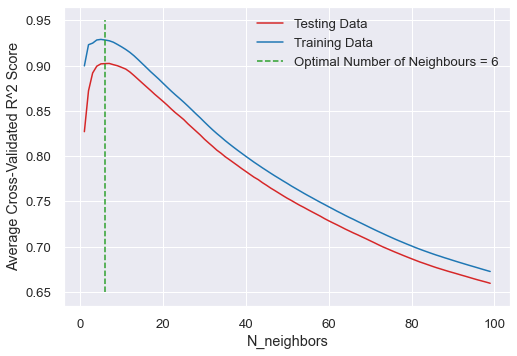

In [628]:
plt.plot(neighbors_settings, avg_r2_test, label="Testing Data", color = "tab:red")
plt.plot(neighbors_settings, avg_r2_train, label="Training Data", color = "tab:blue")
plt.plot([6]*100, np.linspace(0.65, 0.95, 100), "--", color = "tab:green", label = "Optimal Number of Neighbours = 6")
plt.ylabel("Average Cross-Validated R^2 Score")
plt.xlabel("N_neighbors")
plt.legend()

In [624]:
##Visualize the effect of expansion-value (k) on KNN average accuracy
k_values = list(range(7, 90))
average_scores_train = []
average_scores_test = []

for k in k_values:
    df2 = expand_df(df_split, k)
    # Run model at this number of neighbours
    cross_valid_dict_r2, cross_valid_dict_rmse = run_model_KNN_reg(6)

    # Save average R-squared score for each element accross their minimum and maximum limits using previous model
    elems_r2_test = []
    elems_r2_train = []

    # Loop through all elements and find their average R-squared
    j = 0
    for i in range(15):
        elems_r2_test.append((list(cross_valid_dict_r2.values())[i+j][0][0] + list(cross_valid_dict_r2.values())[i+j+1][0][0]) / 2)
        elems_r2_train.append((list(cross_valid_dict_r2.values())[i+j][1][0] + list(cross_valid_dict_r2.values())[i+j+1][1][0]) / 2)
        j += 1

    # Find average R-squared score accross all elements and append it
    average_scores_test.append(sum(elems_r2_test) / len(elems_r2_test))
    average_scores_train.append(sum(elems_r2_train) / len(elems_r2_train))


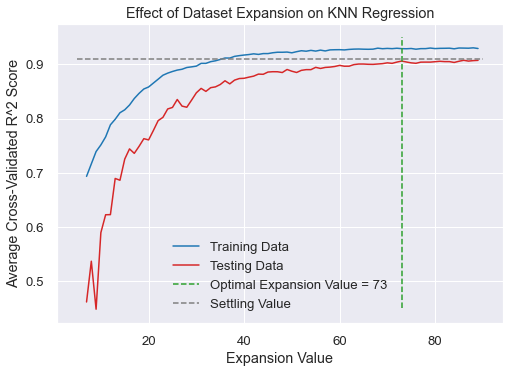

In [635]:
plt.plot(k_values, average_scores_train, color = "tab:blue", label = "Training Data")
plt.plot(k_values, average_scores_test, color = "tab:red", label = "Testing Data")
plt.plot([73]*100, np.linspace(0.45, 0.95, 100), "--", color = "tab:green", label = "Optimal Expansion Value = 73")
plt.plot(np.linspace(5, 90, 100), [0.91]*100, "--", color = "tab:grey", label = "Settling Value")
plt.ylabel("Average Cross-Validated R^2 Score")
plt.xlabel("Expansion Value")
plt.title("Effect of Dataset Expansion on KNN Regression")
plt.legend()
plt.show()

In [636]:
# Function to predict the chemical content of a new datapoint using KNN

def test_point_KNN(point, n=6,  df = df2):
    norm_point = normalize_point(point)
    pred_content = {}
    for elem in list(df2.columns)[21:-1]:
        x_train, x_test, y_train, y_test = split_data(elem)
        reg = KNeighborsRegressor(n_neighbors=n)
        reg.fit(x_train, y_train)
        pred = float("{:.3f}".format(reg.predict(norm_point)[0]))
        pred_content[elem] = pred
    return pred_content
    
test_point = [22, 275, 450]
test_point_KNN(test_point)

{'min_C': 0.0,
 'max_C': 0.173,
 'min_Si': 0.0,
 'max_Si': 0.4,
 'min_Mn': 0.65,
 'max_Mn': 1.483,
 'min_P': 0.0,
 'max_P': 0.027,
 'min_S': 0.0,
 'max_S': 0.019,
 'min_N': 0.0,
 'max_N': 0.108,
 'min_Cu': 0.0,
 'max_Cu': 0.392,
 'min_Cr': 0.0,
 'max_Cr': 0.3,
 'min_Ni': 0.0,
 'max_Ni': 0.4,
 'min_Mo': 0.0,
 'max_Mo': 0.09,
 'min_Al': 0.0,
 'max_Al': 0.08,
 'min_Ti': 0.0,
 'max_Ti': 0.037,
 'min_V': 0.0,
 'max_V': 0.055,
 'min_Nb': 0.0,
 'max_Nb': 0.05,
 'min_B': 0.0,
 'max_B': 0.0}

In [637]:
##Function to determine the steel grade using its predicted chemical contents using KNN regression.

def find_similar_steel(mechanical_properties, df=df2):

    predicted_chemical_content = list(test_point_KNN(mechanical_properties).values())

    unique_steels = []
    unique_steel = ""
    while len(unique_steels) < 3:
        # Remove the grade added to "unique_steels"
        df = df[(df.Grade != unique_steel)]

        # Calculate the difference between the predicted chemical content and the chemical content of each steel grade
        differences = df.iloc[:, 21:-1] - predicted_chemical_content

        # Calculate the Euclidean distance between the predicted chemical content and the chemical content of each steel grade
        distances = (differences ** 2).sum(axis=1)

        # Find the index of the smallest Euclidean distance
        indices_of_most_similar_steels = distances.idxmin()

        # Find the closest steel grade and add it to "unique_steels"
        unique_steel = df.loc[indices_of_most_similar_steels, 'Grade']
        unique_steels.append(unique_steel)
    return unique_steels

find_similar_steel([22, 275, 400])


['PT450GH+N', 'P265NL', 'P275NL1']

In [24]:
df2 = expand_df(df_split, 77)

In [26]:
### Polynomial regression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Train the polynomial regression model
def run_model_poly_reg(degree, n_folds = 5):

    # Define the input independent variable
    X = np.array(normalize_data(df2))

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state = 42)

    # Save the cross-validation score for each element
    cross_valid_dict_r2 = {}
    cross_valid_dict_rmse = {}

    for elem in df2.columns[21:-1]:
        # Define the dependent variable 
        y = np.array(df2[elem].values.tolist())

        # Initialize the r-squared scores list for each fold
        train_r2 = np.zeros(n_folds)
        test_r2 = np.zeros(n_folds)
        train_rmse = np.zeros(n_folds)
        test_rmse = np.zeros(n_folds)

        # Loop over the folds
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            # Split the data into training and test sets
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

            # Fit the model to the training data
            poly_model = PolynomialFeatures(degree=degree, include_bias=False)
            X_poly_train = poly_model.fit_transform(X_train)
            X_poly_test = poly_model.transform(X_test)
            lin_reg = LinearRegression()
            lin_reg.fit(X_poly_train, y_train)
            
            # Make predictions on the training and test data
            y_train_pred = lin_reg.predict(X_poly_train)
            y_test_pred = lin_reg.predict(X_poly_test)
            
            # Compute the R^2 score for the training and test data
            train_r2[i] = r2_score(y_train, y_train_pred)
            test_r2[i] = r2_score(y_test, y_test_pred)

            # Compute the RMSE score for the training and test data
            train_rmse[i] = mean_squared_error(y_train, y_train_pred, squared=False)
            test_rmse[i] = mean_squared_error(y_test, y_test_pred, squared=False)
            
        # Compute the mean and standard deviation of the R^2 scores for the training and test data accross all folds
        mean_train_r2 = np.mean(train_r2)
        std_train_r2 = np.std(train_r2)
        mean_test_r2 = np.mean(test_r2)
        std_test_r2 = np.std(test_r2)

        # Compute the mean and standard deviation of the RMSE scores for the training and test data accross all folds
        mean_train_rmse = np.mean(train_rmse)
        std_train_rmse = np.std(train_rmse)
        mean_test_rmse = np.mean(test_rmse)
        std_test_rmse = np.std(test_rmse)

        # Save the results for each element
        cross_valid_dict_r2[elem] = [[mean_test_r2, std_test_r2], [mean_train_r2, std_train_r2]]
        cross_valid_dict_rmse[elem] = [[mean_test_rmse, std_test_rmse], [mean_train_rmse, std_train_rmse]]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_needed_elems_poly(cross_valid_dict_r2, cross_valid_dict_rmse, degree)
    return cross_valid_dict_r2, cross_valid_dict_rmse

# Run the model
cross_valid_dict_r2_poly, cross_valid_dict_rmse_poly = run_model_poly_reg(13, 5)

In [25]:
# Improve prediction for some elements by removing outliers from their data

# Function for evaluating model after removing needed outliers
def improve_elem_poly(elem, df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree, n_folds = 5):
    X = np.array(normalize_data(df_new))
    y = np.array(df_new[elem].values.tolist())
    kf = KFold(n_splits=n_folds, shuffle=True, random_state = 42)
    train_r2 = np.zeros(n_folds)
    test_r2 = np.zeros(n_folds)
    train_rmse = np.zeros(n_folds)
    test_rmse = np.zeros(n_folds)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        poly_model = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly_train = poly_model.fit_transform(X_train)
        X_poly_test = poly_model.transform(X_test)
        lin_reg = LinearRegression()
        lin_reg.fit(X_poly_train, y_train)
        y_train_pred = lin_reg.predict(X_poly_train)
        y_test_pred = lin_reg.predict(X_poly_test)
        train_r2[i] = r2_score(y_train, y_train_pred)
        test_r2[i] = r2_score(y_test, y_test_pred)
        train_rmse[i] = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse[i] = mean_squared_error(y_test, y_test_pred, squared=False)
    mean_train_r2 = np.mean(train_r2)
    std_train_r2 = np.std(train_r2)
    mean_test_r2 = np.mean(test_r2)
    std_test_r2 = np.std(test_r2)
    mean_train_rmse = np.mean(train_rmse)
    std_train_rmse = np.std(train_rmse)
    mean_test_rmse = np.mean(test_rmse)
    std_test_rmse = np.std(test_rmse)
    cross_valid_dict_r2[elem] = [[mean_test_r2, std_test_r2], [mean_train_r2, std_train_r2]]
    cross_valid_dict_rmse[elem] = [[mean_test_rmse, std_test_rmse], [mean_train_rmse, std_train_rmse]]
    return cross_valid_dict_r2, cross_valid_dict_rmse
    
# Function to improve the elements needing improvement

def improve_needed_elems_poly(cross_valid_dict_r2, cross_valid_dict_rmse, degree):
    # Improve max_Al
    df_new = df2[(df2["max_Al"] != 0.550) & (df2["max_Al"] != 0.200)]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem_poly("max_Al", df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree)


    # Improve min_Si
    df_new = df2[df2["min_Si"] != 0.15]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem_poly("min_Si", df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree)

    # Imrove min_Nb
    df_new = df2[df2["min_Nb"] != 0.015]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem_poly("min_Nb", df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree)

    # Improve max_Nb
    df_new = df2[df2["max_Nb"] != 0.50]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem_poly("max_Nb", df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree)

    #Improve max_N
    df_new = df2[(df2["max_N"] != 12.000) & (df2["max_N"] != 0.300)]
    cross_valid_dict_r2, cross_valid_dict_rmse = improve_elem_poly("max_N", df_new, cross_valid_dict_r2, cross_valid_dict_rmse, degree)

    return cross_valid_dict_r2, cross_valid_dict_rmse

The average R^2 score for Polynomial regression on testing dataset: 0.902
The average R^2 score for Polynomial regression on training dataset: 0.909


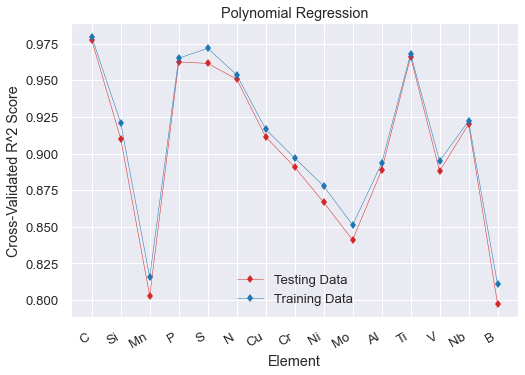

In [27]:
# Find the average cross-validated r-squared score for each element

# Define list which stores average R-squared scores
elems_r2_test_poly = []
elems_r2_std_test_poly = []
elems_r2_train_poly = []
elems_r2_std_train_poly = []

# Loop through all elements and find their average R-squared score accross their minimum and maximum limits
j = 0
for i in range(15):
    elems_r2_test_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][0][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][0][0]) / 2)
    elems_r2_train_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][1][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][1][0]) / 2)
    elems_r2_std_test_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][0][1] + list(cross_valid_dict_r2_poly.values())[i+j+1][0][1]) / 2)
    elems_r2_std_train_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][1][1] + list(cross_valid_dict_r2_poly.values())[i+j+1][1][1]) / 2)
    j += 1

# Plot the average cross-validated R-squared score for each element in training and testing data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], elems_r2_test_poly, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], elems_r2_train_poly, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
fig.autofmt_xdate()
plt.ylabel("Cross-Validated R^2 Score")
plt.xlabel("Element")
plt.title("Polynomial Regression")
plt.legend()

# Find the average cross-validated r-squared score for training and testing data accross all elements
avg_r2_test_poly = sum(elems_r2_test_poly) / len(elems_r2_test_poly)
avg_r2_train_poly = sum(elems_r2_train_poly) / len(elems_r2_train_poly)
print("The average R^2 score for Polynomial regression on testing dataset: {:.3f}".format(avg_r2_test_poly))
print("The average R^2 score for Polynomial regression on training dataset: {:.3f}".format(avg_r2_train_poly))

The average R^2 score for Polynomial regression on testing dataset: 0.072
The average R^2 score for Polynomial regression on training dataset: 0.067


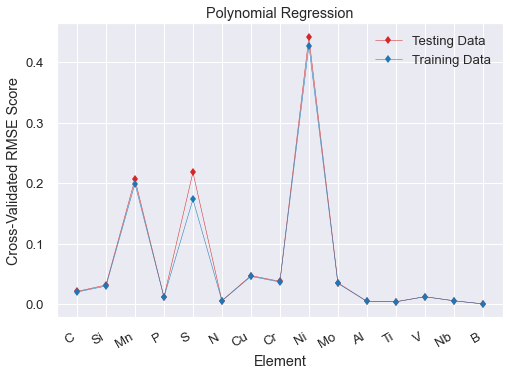

In [28]:
# Find average error for each element

# Define list which stores average RMSE scores
rmse_scores_poly = []
rmse_scores_train_poly = []

# Loop through all elements and find their average RMSE score accross their minimum and maximum limits
j = 0
for i in range(15):
    rmse_scores_poly.append((list(cross_valid_dict_rmse_poly.values())[i+j][0][0] + list(cross_valid_dict_rmse_poly.values())[i+j+1][0][0]) / 2)
    rmse_scores_train_poly.append((list(cross_valid_dict_rmse_poly.values())[i+j][1][0] + list(cross_valid_dict_rmse_poly.values())[i+j+1][1][0]) / 2)
    j += 1

# Plot the average cross-validated RMSE score for each element in training and testing data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], rmse_scores_poly, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], rmse_scores_train_poly, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
fig.autofmt_xdate()
plt.ylabel("Cross-Validated RMSE Score")
plt.xlabel("Element")
plt.title("Polynomial Regression")
plt.legend()

# Find the average cross-validated RMSE score for training and testing data accross all elements
avg_rmse_test_poly = sum(rmse_scores_poly) / len(rmse_scores_poly)
avg_rmse_train_poly = sum(rmse_scores_train_poly) / len(rmse_scores_train_poly)
print("The average R^2 score for Polynomial regression on testing dataset: {:.3f}".format(avg_rmse_test_poly))
print("The average R^2 score for Polynomial regression on training dataset: {:.3f}".format(avg_rmse_train_poly))

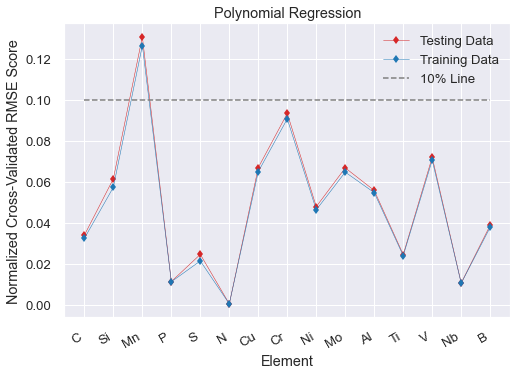

In [29]:
# Find the normalized RMSE score (RMSE score / range of output variable) for each element

# Find weighted RMSE score for min and max of each element
weighted_rmse_dict_poly = {}
for i in range(len(cross_valid_dict_rmse)):
    elem = list(cross_valid_dict_rmse_poly.keys())[i]
    elem_range = df2[elem].max() - df2[elem].min()
    if elem_range == 0:
        weighted_rmse_test = 0
        weighted_rmse_train = 0
    else:
        weighted_rmse_test = cross_valid_dict_rmse_poly[elem][0][0] / elem_range
        weighted_rmse_train = cross_valid_dict_rmse_poly[elem][1][0] / elem_range
    weighted_rmse_dict_poly[elem] = [weighted_rmse_test, weighted_rmse_train]

# Find average of weighted RMSE score for each element accross minimum and maximum limits
weighted_rmse_scores_test_poly = []
weighted_rmse_scores_train_poly = []
j = 0
for i in range(15):
    weighted_rmse_scores_test_poly.append((list(weighted_rmse_dict_poly.values())[i+j][0] + list(weighted_rmse_dict_poly.values())[i+j+1][0]) / 2)
    weighted_rmse_scores_train_poly.append((list(weighted_rmse_dict_poly.values())[i+j][1] + list(weighted_rmse_dict_poly.values())[i+j+1][1]) / 2)
    j += 1

# Plot average weighted RMSE score for each element
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bs_df.columns[5:-1], weighted_rmse_scores_test_poly, marker = "d", color ="tab:red", linewidth = 0.5, label = "Testing Data")
ax.plot(bs_df.columns[5:-1], weighted_rmse_scores_train_poly, marker = "d", color ="tab:blue", linewidth = 0.5, label = "Training Data")
plt.plot(np.linspace(0, 14, 100), [0.1]*100, "--", color = "tab:grey", label = "10% Line")
fig.autofmt_xdate()
plt.ylabel("Normalized Cross-Validated RMSE Score")
plt.xlabel("Element")
plt.title("Polynomial Regression")
plt.legend()

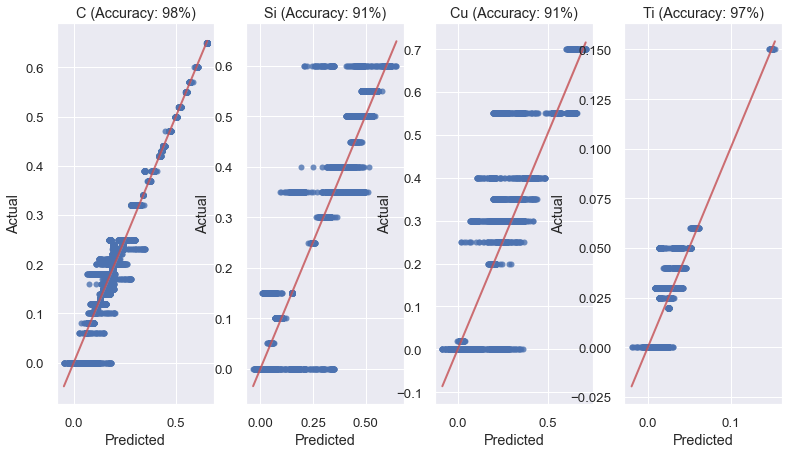

In [30]:
##Visualize polynomial regression performance on example elements

#Elements to plot their performance
example_elems = ['C','Si','Cu', "Ti"]
accuracy = [98, 91, 91, 97]

#Scatter plot of predicted vs actual output for example elements
#Create figure and axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 7))
axes = [ax1, ax2, ax3, ax4]

for i in range(len(example_elems)):
    #Plot prediction vs actual for each element
    x_train, x_test, y_train, y_test = split_data("min_"+example_elems[i], df2)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)

    x_train_2, x_test_2, y_train_2, y_test_2 = split_data("max_"+example_elems[i], df2)
    poly_2 = PolynomialFeatures(degree=13, include_bias=False)
    poly_features_2 = poly.fit_transform(np.array(x_train_2))
    poly_reg_model_2 = LinearRegression()
    poly_reg_model_2.fit(poly_features, np.array(y_train_2))
    y_pred_2 = poly_reg_model_2.predict(poly_features_2)

    y_total = y_train + y_train_2
    y_pred = list(y_pred)
    for j in range(len(y_pred_2)):
        y_pred.append(y_pred_2[j])

    sns.regplot(x=y_pred, y=y_total, line_kws={"color":"r","alpha":0.8,"lw":2}, ax=axes[i]).set(
        title=example_elems[i]+" (Accuracy: {}%)".format(accuracy[i]), xlabel='Predicted', ylabel='Actual')
plt.show()
plt.close()

In [649]:
## Visualize the effect of hyperparameters
#  The effect of the polynomial's degree on accuracy

# Define list which stores average R-squared scores
avg_r2_test_poly = []
avg_r2_train_poly = []

degree_settings = range(1, 20)

# Loop through every degree setting
for n in degree_settings:
    # Run model at this number of neighbours
    cross_valid_dict_r2_poly, cross_valid_dict_rmse_poly = run_model_poly_reg(n)

    # Save average R-squared score for each element accross their minimum and maximum limits using previous model
    elems_r2_test_poly = []
    elems_r2_train_poly = []

    # Loop through all elements and find their average R-squared
    j = 0
    for i in range(15):
        elems_r2_test_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][0][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][0][0]) / 2)
        elems_r2_train_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][1][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][1][0]) / 2)
        j += 1

    # Find average R-squared score accross all elements and append it
    avg_r2_test_poly.append(sum(elems_r2_test_poly) / len(elems_r2_test_poly))
    avg_r2_train_poly.append(sum(elems_r2_train_poly) / len(elems_r2_train_poly))

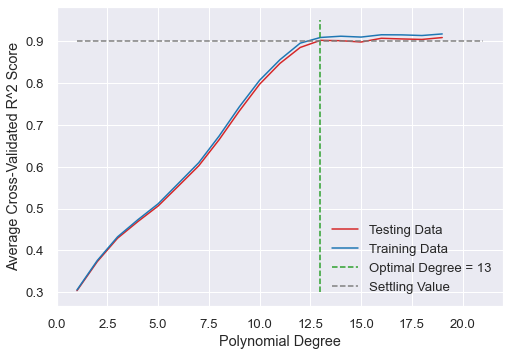

In [657]:
plt.plot(degree_settings, avg_r2_test_poly, label="Testing Data", color = "tab:red")
plt.plot(degree_settings, avg_r2_train_poly, label="Training Data", color = "tab:blue")
plt.plot([13]*100, np.linspace(0.3, 0.95, 100), "--", color = "tab:green", label = "Optimal Degree = 13")
plt.plot(np.linspace(1, 21, 100), [0.90]*100, "--", color = "tab:grey", label = "Settling Value")
plt.ylabel("Average Cross-Validated R^2 Score")
plt.xlabel("Polynomial Degree")
plt.legend()

In [658]:
## Visualize the effect of expansion-value (k) on polynomial-regression average accuracy

k_values = list(range(3, 90))
# Define list which stores average R-squared scores
avg_r2_test_poly_lst = []
avg_r2_train_poly_lst = []

# Loop through every neighbours setting
for k in k_values:
    # Save average R-squared score for each element accross their minimum and maximum limits using previous model
    elems_r2_test_poly = []
    elems_r2_train_poly = []

    # Create expanded dataset and run model
    df2 = expand_df(df_split, k)
    cross_valid_dict_r2_poly, cross_valid_dict_rmse_poly = run_model_poly_reg(13, 5)

    # Loop through all elements and find their average R-squared score accross their minimum and maximum limits
    j = 0
    for i in range(15):
        elems_r2_test_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][0][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][0][0]) / 2)
        elems_r2_train_poly.append((list(cross_valid_dict_r2_poly.values())[i+j][1][0] + list(cross_valid_dict_r2_poly.values())[i+j+1][1][0]) / 2)
        j += 1


    # Find the average cross-validated r-squared score for training and testing data accross all elements
    avg_r2_test_poly = sum(elems_r2_test_poly) / len(elems_r2_test_poly)
    avg_r2_train_poly = sum(elems_r2_train_poly) / len(elems_r2_train_poly)
    avg_r2_test_poly_lst.append(avg_r2_test_poly)
    avg_r2_train_poly_lst.append(avg_r2_train_poly)


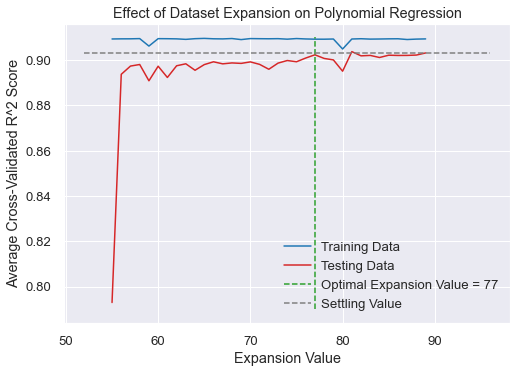

In [718]:
plt.plot(k_values[52:], avg_r2_train_poly_lst[52:], color = "tab:blue", label = "Training Data")
plt.plot(k_values[52:], avg_r2_test_poly_lst[52:], color = "tab:red", label = "Testing Data")
plt.plot([77]*100, np.linspace(0.79, 0.91, 100), "--", color = "tab:green", label = "Optimal Expansion Value = 77")
plt.plot(np.linspace(52, 96, 100), [0.903]*100, "--", color = "tab:grey", label = "Settling Value")
plt.ylabel("Average Cross-Validated R^2 Score")
plt.xlabel("Expansion Value")
plt.title("Effect of Dataset Expansion on Polynomial Regression")
plt.legend(loc=4)
plt.show()

In [661]:
#Find grade using polynomial regression.
##Function to determine the steel grade using its predicted chemical contents.
##It'll go through every grade, calculate the error for each element, and pick the grade with least error.

def find_similar_steel_poly(mechanical_properties, df=df2):

    predicted_chemical_content = list(test_point_poly(mechanical_properties).values())

    unique_steels = []
    unique_steel = ""
    while len(unique_steels) < 3:
        # Calculate the difference between the predicted chemical content and the chemical content of each steel grade
        df = df[(df.Grade != unique_steel)]
        differences = df.iloc[:, 21:-1] - predicted_chemical_content

        # Calculate the Euclidean distance between the predicted chemical content and the chemical content of each steel grade
        distances = (differences ** 2).sum(axis=1)
        # Find the indices of the three smallest Euclidean distances
        indices_of_most_similar_steels = distances.idxmin()

        # Return the three steel grades with the most similar chemical content
        unique_steel = df.loc[indices_of_most_similar_steels, 'Grade']
        unique_steels.append(unique_steel)
    return unique_steels

find_similar_steel_poly([20, 355, 490])

['P275NL1', 'P275NH', 'P275NL2']

In [660]:
# Function to predict the chemical content of a new datapoint using poltnomial regression
def test_point_poly(point, df=df2, n=14):
    norm_point = normalize_point(point)
    pred_content = {}
    for elem in list(df.columns)[21:-1]:
        x_train, x_test, y_train, y_test = split_data(elem)
        # Create a polynomial features object with degree n
        poly_features = PolynomialFeatures(degree=n, include_bias=False)

        # Transform the training input data into polynomial features
        x_train_poly = poly_features.fit_transform(x_train)

        # Train a linear regression model on the polynomial features
        poly_reg = LinearRegression().fit(x_train_poly, y_train)

        # Transform the test input data into polynomial features
        x_test_poly = poly_features.transform(norm_point)

        # Predict the output for the test input data
        y_test_pred = poly_reg.predict(x_test_poly)[0]
        if y_test_pred < 0:
            y_test_pred = 0

        pred_content[elem] = y_test_pred
    return pred_content

# Test a new point
test_point = [22, 275, 450]
print(test_point_poly(test_point))

{'min_C': 0, 'max_C': 0.17756764590740204, 'min_Si': 0.0003025457262992859, 'max_Si': 0.3975852131843567, 'min_Mn': 0.6463041305541992, 'max_Mn': 1.4689877033233643, 'min_P': 0.0, 'max_P': 0.027306636795401573, 'min_S': 0.00021066702902317047, 'max_S': 0, 'min_N': 0.0, 'max_N': 0.02269136905670166, 'min_Cu': 0.0, 'max_Cu': 0.363677722401917, 'min_Cr': 0.0, 'max_Cr': 0.29958220571279526, 'min_Ni': 0.001142948865890503, 'max_Ni': 0.39593997597694397, 'min_Mo': 0.0006182936485856771, 'max_Mo': 0.09073883015662432, 'min_Al': 0, 'max_Al': 0.05052781291306019, 'min_Ti': 0.0, 'max_Ti': 0.03393142111599445, 'min_V': 7.46091827750206e-05, 'max_V': 0.06057329103350639, 'min_Nb': 0, 'max_Nb': 0.050134158693253994, 'min_B': 0, 'max_B': 0}
